## 4. Fundamenta_hedge
买入股票，同时当大盘价格低于MA40时卖出1手股指对冲风险。

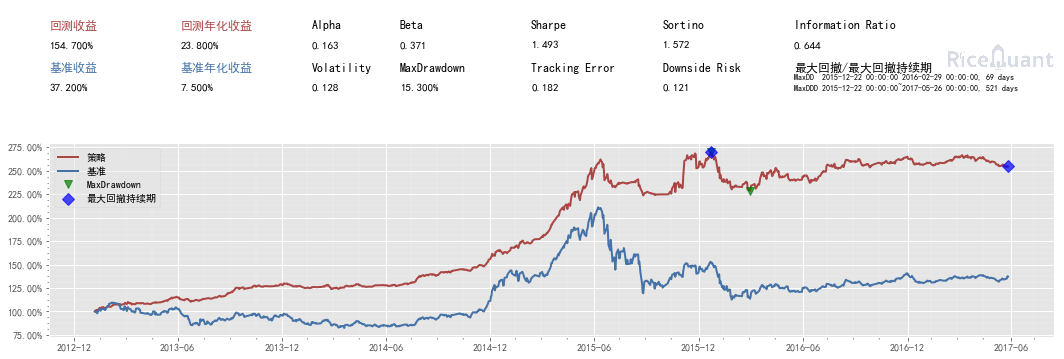

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2013-01-07  1261.72   19998738.28                  1.000  20000000.00   
  2013-01-08  1261.72   19914752.38                  1.000  19916014.10   
  2013-01-09  1261.72   19921061.18                  0.996  19922322.90   
  2013-01-10  1261.72   19956075.02                  0.996  19957336.74   
  2013-01-11  1261.72   19582751.78                  0.998  19584013.50   
  2013-01-14  1261.72   20327899.92                  0.979  20329161.64   
  2013-01-15  1261.72   20470951.96                  1.016  20472213.68   
  2013-01-16  1261.72   20322931.74                  1.024  20324193.46   
  2013-01-17  1261.72   20131065.36                  1.016  20132327.08   
  2013-01-18  1261.72   20467639.84                  1.007  20468901.56   
  2013-01-21  1261.72   20589557.40                  1.023  2

In [2]:
#coding=utf-8
# run_code_demo
from rqalpha import run_code

code = """

import numpy as np
import talib as ta
import pandas as pd
import rqalpha
from rqalpha.api import *
from fxdayu_data import DataAPI
from rqalpha.const import INSTRUMENT_TYPE

def init(context):
    DataAPI.set_file('D:/PycharmProjects/Quant_Alpha/Data_Manager/Valuation_Selection/config.py')
    df = DataAPI.candle('000001.XSHG', 'D')
    df['MA_hedge'] = ta.abstract.MA(df, 30)
    context.df = df
    codes = pd.read_excel('C:/Users/small/Desktop/july_first/Value_Selection.xlsx')
    codes.index = codes.pop('date')
    context.codes = codes

def find_pool(context, date):
    codes = context.codes.loc[date]
    stocks = codes.index[codes == True]
    return stocks

def handle_bar(context, bar_dict):
    hedge(context)
    buy(context, bar_dict)

def buy(context, bar_dict):
    pool = find_pool(context, context.now)
    if pool is not None:
        stocks_len = len(pool)

    for stock in context.portfolio.positions:
        instrument = instruments(stock)
        if instrument.enum_type == INSTRUMENT_TYPE.FUTURE:
            continue
        if stock not in pool:
            order_target_percent(stock, 0)
    result = []
    for codes in pool:
        data_c = history_bars(codes, 25, '1d', 'close', adjust_type='post')
        ma = ta.MA(data_c, timeperiod=20)
        if len(ma) > 3 and context.df.close.loc[context.now] > context.df.MA_hedge.loc[context.now]:
            if ma[-1] > ma[-2] and ma[-2] > ma[-3] and codes not in result and codes not in context.portfolio.positions:
                result.append(codes)

    if len(result):
        for r in result:
            order_target_percent(r, 1.0 / stocks_len)


def hedge(context):
    for future in get_future_contracts("IF"):
        try:
            sell_qty = context.portfolio.positions[future].sell_quantity
            if context.df.close.loc[context.now] < context.df.MA_hedge.loc[context.now] and sell_qty == 0:
                sell_open(future, 1)
            if context.df.close.loc[context.now] > context.df.MA_hedge.loc[context.now] and sell_qty > 0:
                buy_close(future, 1)
        except RQInvalidArgument:
            continue
"""

config = {
    "base": {
        "start_date": "2013-01-07",
        "end_date": "2017-05-30",
        "frequency": '1d',
        "securities": ['stock', 'future'],
        "stock_starting_cash": 10000000,
        "future_starting_cash": 10000000,
        "benchmark": "000300.XSHG"
    },
    "extra": {
        "log_level": "verbose",
    },
    "mod": {
        "sys_analyser": {
            "report_save_path": '.',
            "enabled": True,
            "plot": True
        }
    }
}

run_code(code, config)
